In [ ]:
#| hide
from nbdev import *

# HECSS
> High Efficiency Configuration Space Sampler

HECSS is a Monte-Carlo, configuration space sampler using sample weighting algorithm for probability distribution sampling. It provides an alternative way to create representations of systems at thermal equilibrium without running a very expensive molecular dynamics simulation. The theoretical foundation of the code are presented in the section [Background](00_Background.html) in the [Documentation](https://jochym.gitlab.io/hecss/). More detailed examples are included in the [LAMMPS](01_LAMMPS_Tutorial.html) and [VASP](01_VASP_Tutorial.html) tutorials.

You can try HECSS on binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/jochym%2Fhecss/devel?labpath=index.ipynb)

[![PVersion Badge](https://img.shields.io/pypi/v/hecss.svg)](https://pypi.org/project/hecss/)
[![PDownloads Badge](https://img.shields.io/pypi/dm/hecss.svg)](https://pypi.org/project/hecss/)
[![CVersion Badge](https://anaconda.org/conda-forge/hecss/badges/version.svg)](https://anaconda.org/conda-forge/hecss)
[![Downloads Badge](https://anaconda.org/conda-forge/hecss/badges/downloads.svg)](https://anaconda.org/conda-forge/hecss)
[![License Badge](https://anaconda.org/jochym/hecss/badges/license.svg)](https://anaconda.org/jochym/hecss)
[![GHCI](https://github.com/jochym/hecss/actions/workflows/test.yaml/badge.svg?branch=devel)](https://github.com/jochym/hecss/actions/workflows/test.yaml)
[![GLCI](https://gitlab.com/jochym/hecss/badges/devel/pipeline.svg)](https://gitlab.com/jochym/hecss/-/commits/devel)


## A very short example

Minimal example using LAMMPS potential from the asap3 package and OpenKIM database. Here we will sample the thermodynamic distribution of 3C-SiC crystal at 300K. We start by importing required modules, define the crystal and energy/forces calculator, run the sampler and finally plot the energy distribution. 

In [ ]:
#| asap
from hecss import HECSS
from hecss.util import select_asap_model, create_asap_calculator
from hecss.monitor import plot_stats
from ase.build import bulk

Then we define the crystal and interaction model used in the calculation. In this case we use 3x3x3 supercell of the SiC crystal in zincblende structure and describe the interaction using LAMMPS potential from the OpenKIM database and ASAP3 implementation of the calculator.

In [ ]:
#| asap
model = select_asap_model('SiC')
cryst = bulk('SiC', crystalstructure='zincblende', 
             a=4.38120844, cubic=True).repeat((3,3,3))
cryst.set_calculator(create_asap_calculator(model))

Then we define the sampler parameters (N -- number of samples, T -- temperature) and run it. The parameter with the `lambda` anonymous function is required in this case, due to the peculiarities of the ASAP implementation of the ASE calculator which cannot be re-used when the sampler is re-executed. This construct is probably not required for other calculators.

In [ ]:
#| asap
T = 300
N = 100
hecss = HECSS(cryst, lambda : create_asap_calculator(model))
samples = hecss.sample(T, N)
distrib = hecss.generate(samples, T)

And finally we plot the histogram of the resulting energy distribution which corresponds to the thermal equilibrium distribution.

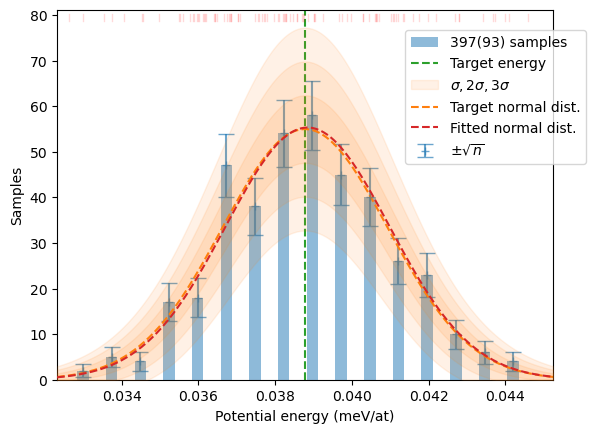

In [ ]:
#| asap
plot_stats(distrib, T, sqrN=True)

## Install

The HECSS package is avaliable on pypi and conda-forge additionally the package is present also in my personal anaconda channel (jochym). Installation is simple, but requires a number of other packages to be installed as well. Package menagers handle these dependencies automatically. 

### Install with pip
It is advisable to install in a dedicated virtual environment e.g.:
```bash
python3 -m venv venv
. venv/bin/activate
```
then install with `pip`:
```bash
pip install hecss
```

### Install with conda
Also installation with conda should be performed for dedicated or some other non-base environment. To create dedicated environment you can invoke `conda create`:
```bash
conda create -n hecss -c conda-forge hecss
```
or you can install in some working environment `venv`:
```bash
conda install -n venv -c conda-forge hecss
```

### Example data archive

The example subdirectory from the source may be downloaded directly from the source repository: [hecss-examples.zip](https://gitlab.com/jochym/hecss/-/archive/master/hecss-master.zip?path=example) 

### The source code

The source is published at the [Gitlab hecss repository](https://gitlab.com/jochym/hecss). 
You can access it with git (recommended, particularly if you want to contribute to the development):
```bash
git clone https://gitlab.com/jochym/hecss.git
```
or you can download the whole distribution as a zip archive: [hecss.zip](https://gitlab.com/jochym/hecss/-/archive/master/hecss-master.zip)